# Домашнее задание 3: Imitation Learning (Behavioral Cloning и DAgger)

В этом задании вы познакомитесь с методами **имитационного обучения (Imitation Learning)** — подходом к обучению агентов, при котором они учатся напрямую копировать поведение эксперта, не получая при этом явного сигнала награды от среды. Такие методы особенно полезны, когда:
- награда разрежена или недоступна,
- экспертное поведение легко продемонстрировать, но трудно формализовать,
- требуется быстро получить рабочую политику без длительного взаимодействия со средой.

Вы реализуете два ключевых алгоритма:
1. **Behavioral Cloning (BC)** — простейший метод, сводящийся к задаче регрессии: по состоянию предсказать действие эксперта.
2. **DAgger (Dataset Aggregation)** — итеративный метод, который решает проблему *covariate shift*, активно собирая опыт в тех состояниях, куда попадает обучаемая политика.

## План задания и распределение баллов

| Этап | Описание | Максимум баллов |
|------|---------|------------------|
| **1. Оценка эксперта** | Оценка производительности предобученного эксперта (жадная и стохастическая политики), реализация IQM и визуализация поведения | **3 балла** |
| **2. Сбор датасета** | Генерация датасета траекторий от эксперта и сохранение в HDF5 | **2 балла** |
| **3. Behavioral Cloning** | Реализация нейросетевой архитектуры, обучение BC и оценка качества | **5 баллов**<br>— 2 балла за `MLPBlock`<br>— 2 балла за `MLPActHead`<br>— 1 балл за обучение и оценку |
| **4. Анализ BC** | Исследование зависимости качества BC от размера датасета с использованием IQM и сравнением in/out-of-distribution оценок | **5 баллов** |
| **5. DAgger** | Реализация итеративного алгоритма DAgger, сбор новых данных с участием эксперта и анализ сходимости | **5 баллов** |
| **Итого** | | **20 баллов** |

> 💡 **Совет**: начните с малых экспериментов (например, 10 траекторий) для отладки, и только затем масштабируйтесь до полного датасета (1024 траектории). Это сэкономит время и ресурсы Colab.

Удачи!

## Установка среды

In [1]:
import os
os.environ["MUJOCO_GL"] = "egl"
os.environ["PYOPENGL_PLATFORM"] = "egl"

# import os
# if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
#     !bash xvfb start
#     os.environ['DISPLAY'] = ':1'

!pip install dm_control>=1.0.34  #torch==2.2.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install shimmy[dm-control]
!pip install gymnasium
!pip install torchinfo

# import warnings; warnings.filterwarnings(action="ignore", message=r"datetime.datetime.utcnow")
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="pkg_resources")
warnings.filterwarnings("ignore", message="datetime.datetime.utcnow")

## Проверка установки и рендеринг среды MuJoCo  
Убедитесь, что среда корректно установлена и можно получить изображения из неё.


In [2]:
import gymnasium as gym
import numpy as np
from dm_control import suite
from dm_control.suite.wrappers import pixels
from shimmy import DmControlCompatibilityV0

warnings.filterwarnings(action="ignore", message=r"datetime.datetime.utcnow")

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

### Обёртка для рендеринга в средах DeepMind Control Suite  
Поскольку оригинальная среда `dm_control` не предоставляет метод `.render()` в формате, совместимом с Gymnasium, мы создаём собственную обёртку `DmControlWithRender`.  
Эта обёртка добавляет метод `render()`, который использует встроенный рендерер MuJoCo для получения изображений заданного разрешения и с нужной камеры.

In [3]:
class DmControlWithRender(gym.Wrapper):
    def __init__(self, env, height=84, width=84, camera_id=0):
        super().__init__(env)
        self._height = height
        self._width = width
        self._camera_id = camera_id

    def render(self):
        # Access the underlying dm_control env
        dm_env = self.unwrapped._env
        return dm_env.physics.render(
            height=self._height,
            width=self._width,
            camera_id=self._camera_id
        )

### Фабрика среды (`make_env`)  
Функция `make_env` создаёт настраиваемую среду с поддержкой различных полезных обёрток из Gymnasium:

- **`domain`, `task`** — определяют конкретную задачу (например, `"cheetah"` / `"run"`).
- **`frame_stack`** — количество последовательных наблюдений, объединяемых в одно состояние (полезно при обучении на изображениях или для учёта динамики).
- **`flatten_frames`** — если включено, наблюдения (даже стекированные) преобразуются в одномерный вектор.
- **`render_enabled`** — добавляет возможность рендеринга через обёртку `DmControlWithRender`.
- **`record_stats`** — включает сбор статистики по эпизодам (награда, длина и т.д.).
- **`transform_reward`** — применяет нормализацию и ограничение награды (использовалось при обучении эксперта).
- **`hw`** — высота и ширина изображения при рендеринге. Рекомендуется использовать небольшие значения (например, 64) для ускорения работы; максимальное разрешение — 480×480.

Эта функция возвращает *thunk* — callable без аргументов, который создаёт и возвращает готовую среду. Такой подход удобен при векторизации сред (например, через `gym.vector.SyncVectorEnv`).

In [4]:
def make_env(
        domain,
        task,
        frame_stack=1,
        flatten_frames=True,
        render_enabled=True,
        record_stats=False,
        transform_reward=False,
        gamma=0.99,
        hw=64,
    ):
    def thunk():
        dm_env = suite.load(
            domain_name=domain,
            task_name=task,
            task_kwargs=None,
            environment_kwargs=None,
            visualize_reward=False,
        )
        env = DmControlCompatibilityV0(dm_env)
        env = gym.wrappers.FlattenObservation(env) # dict obs -> vector

        # Only add render method if needed (doesn't affect obs)
        if render_enabled:
            env = DmControlWithRender(env, height=hw, width=hw)

        # Observation is always numeric state → consistent!
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            env = gym.wrappers.DtypeObservation(env, np.float32)
        if record_stats:
          env = gym.wrappers.RecordEpisodeStatistics(env)
        env = gym.wrappers.ClipAction(env)
        if transform_reward:
          env = gym.wrappers.NormalizeReward(env, gamma=gamma)
          env = gym.wrappers.TransformReward(env, lambda r: np.clip(r, -10, 10))

        # if frame_stack > 1:
        env = gym.wrappers.FrameStackObservation(env, stack_size=frame_stack)
        if flatten_frames:
            env = gym.wrappers.FlattenObservation(env)
        return env
    return thunk

**Инициализация среды**

Чтобы создать **одну** среду, достаточно вызвать фабричную функцию `make_env` и сразу же выполнить возвращаемый *thunk*:

```python
env = make_env(domain="cheetah", task="run", ...)()
```

Этот вызов создаёт экземпляр среды с заданными параметрами и готов к использованию: можно вызывать `env.reset()`, `env.step(action)` и т.д.

**Немного о векторизованных средах**  (`SyncVectorEnv`)

Однако при обучении агентов (особенно с помощью методов типа PPO или A2C) часто требуется **параллельно взаимодействовать с несколькими копиями среды**. Это позволяет:
- ускорить сбор данных за счёт параллелизма,
- уменьшить корреляцию между последовательными наблюдениями,
- стабилизировать обучение за счёт более разнообразного опыта.

Для этого в Gymnasium предусмотрен класс `SyncVectorEnv`, который объединяет несколько независимых сред в один векторизованный объект. Пример:

```python
from gymnasium.vector import SyncVectorEnv

num_envs = 4
envs = SyncVectorEnv([
    make_env(domain="cheetah", task="run", ...)
    for _ in range(num_envs)
])
```

Теперь `envs` ведёт себя как единая среда, но на самом деле управляет `num_envs` независимыми инстансами:
- `envs.reset()` возвращает массив наблюдений формы `(num_envs, obs_dim)`,
- `envs.step(actions)` принимает массив действий формы `(num_envs, act_dim)` и возвращает соответствующие награды, следующие состояния и флаги завершения.

Важно: `SyncVectorEnv` работает **синхронно** — все среды выполняются последовательно в основном потоке. Для настоящего параллелизма (в отдельных процессах) можно использовать `AsyncVectorEnv`, но для большинства учебных и прототипных задач `SyncVectorEnv` более чем достаточно и проще в отладке.

Этот подход используется, например, при загрузке эксперта: даже если нужна всего одна среда, её всё равно удобно оборачивать в `SyncVectorEnv`, чтобы архитектура агента (`Agent`) могла работать с батчами наблюдений (`envs.single_observation_space` и `envs.single_action_space` дают доступ к пространству одной среды).

In [5]:
# Cоздайте среду для задачи cheetah run
env = make_env(domain="cheetah", task="run")()

In [6]:
env.observation_space

Box(-inf, inf, (17,), float32)

In [7]:
env.action_space

Box(-inf, inf, (6,), float64)

In [8]:
env.reset()

(array([-1.24728121e-01,  4.73383255e-02,  3.25654931e-02,  6.49036542e-02,
        -1.25548653e-02, -4.44935150e-02, -1.27590120e-01, -1.17146015e-01,
         2.66997679e-03, -5.59699329e-05, -1.38910313e-03,  3.10134306e-03,
         2.53424910e-03,  5.06460108e-03,  3.36515834e-03,  7.65765319e-04,
         1.74639956e-03], dtype=float32),
 {'timestep.discount': None, 'timestep.step_type': <StepType.FIRST: 0>})

array([[[ 67, 100, 134],
        [ 67, 100, 134],
        [ 69, 102, 136],
        ...,
        [ 68, 101, 135],
        [ 70, 103, 136],
        [ 67, 101, 135]],

       [[ 66, 100, 133],
        [ 66, 100, 133],
        [ 66, 100, 134],
        ...,
        [ 68, 101, 134],
        [ 67, 101, 134],
        [ 66, 100, 133]],

       [[ 66,  99, 133],
        [ 66,  99, 133],
        [ 66, 100, 133],
        ...,
        [ 72, 104, 137],
        [ 67, 100, 133],
        [ 67, 100, 133]],

       ...,

       [[ 36,  54,  72],
        [ 36,  54,  72],
        [ 38,  56,  74],
        ...,
        [ 39,  56,  74],
        [ 36,  54,  72],
        [ 38,  56,  73]],

       [[ 35,  53,  70],
        [ 35,  53,  70],
        [ 36,  53,  71],
        ...,
        [ 36,  53,  71],
        [ 35,  53,  71],
        [ 36,  54,  71]],

       [[ 36,  54,  71],
        [ 35,  52,  70],
        [ 35,  52,  70],
        ...,
        [ 39,  57,  74],
        [ 36,  53,  71],
        [ 35,  52,  70]]], dtype=uint8)
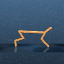

In [9]:
env.render()

Среда **MuJoCo** (в рамках DeepMind Control Suite) предоставляет множество различных задач, каждая из которых может рендериться с разных камер и имеет свои особенности динамики. Например:

- `walker / walk` — двуногий ходячий робот, обучающийся устойчиво передвигаться;
- `hopper / hop` — одноногий прыгающий агент;
- `cartpole / balance` — классическая задача балансировки на тележке;
- `reacher / easy` — манипулятор, который должен дотянуться до цели;
- `finger / spin` — задача вращения объекта с помощью двухпалого захвата;
- `cheetah / run` — четвероногий робот-гепард, обучающийся бегу вперёд.

Все эти среды поддерживают рендеринг с разных точек зрения (камер), что позволяет визуализировать поведение агента под разными углами. Однако для данного домашнего задания мы будем использовать только одну задачу — **`cheetah / run`**, так как именно для неё предоставлен экспертный агент и датасет.

## Загрузка экспертного агента

Загружаем предобученного эксперта — агента, обученного с помощью PPO.  

Для работы с этим заданием рекомендуется:

1. [Скачать папку](https://drive.google.com/drive/folders/1KAHb73CbOvmtGLKFVOHPUjQ44tFy74Mw?usp=sharing) с весами и конфигурацией к себе на **Google Диск**. В этой папке вы можете найти чекпоинты для 3х сред: `cheetah-run`, `hopper-hop` и `walker-run`, однако для этого задания нам понадобятся только `cheetah-run`.
2. Подключить Google Диск к среде Colab.


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


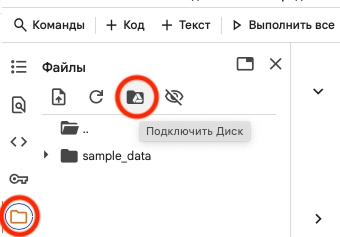

3. Убедиться, что путь `checkpoint_path` указывает на правильное расположение файлов `config.pt` и `checkpoint.pt`.

In [11]:
ls "/content/drive/MyDrive/cheetah-run-expert/"

checkpoint.pt  config.pt


In [12]:
checkpoint_path = "/content/drive/MyDrive/cheetah-run-expert/"
config_name = "config.pt"
checkpoint_name = "checkpoint.pt"

### Вспомогательные функции для нормализации наблюдений

Для стабильного обучения и оценки политик в RL часто используется **нормализация наблюдений** — приведение входных данных к нулевому среднему и единичной дисперсии.  
Класс `RunningMeanStd` реализует **онлайн-оценку среднего и дисперсии** по приходящим батчам данных, используя **параллельный алгоритм обновления моментов**.

Этот подход позволяет:
- эффективно обновлять статистики без хранения всей истории,
- корректно объединять статистики из разных источников (например, при распределённом сборе данных),
- избежать численной нестабильности, связанной с наивным подсчётом дисперсии.

In [13]:
import torch
import torch.nn as nn
from torch.distributions.normal import Normal

def update_mean_var_count_from_moments(mean, var, count, batch_mean, batch_var, batch_count):
    """Updates the mean, var and count using the previous mean, var, count and batch values."""
    delta = batch_mean - mean
    tot_count = count + batch_count

    new_mean = mean + delta * batch_count / tot_count
    m_a = var * count
    m_b = batch_var * batch_count
    M2 = m_a + m_b + torch.square(delta) * count * batch_count / tot_count
    new_var = M2 / tot_count
    new_count = tot_count

    return new_mean, new_var, new_count


class RunningMeanStd(nn.Module):
    """Tracks the mean, variance and count of values."""

    # https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance#Parallel_algorithm
    def __init__(self, shape=(), epsilon=1e-4, dtype=torch.float32):
        super().__init__()
        """Tracks the mean, variance and count of values."""
        self.register_buffer("mean", torch.zeros(shape, dtype=dtype))
        self.register_buffer("var", torch.zeros(shape, dtype=dtype))
        self.register_buffer("count", torch.as_tensor(epsilon, dtype=dtype))

    def update(self, x):
        """Updates the mean, var and count from a batch of samples."""
        batch_mean = torch.mean(x, dim=0)
        batch_var = torch.var(x, dim=0)
        batch_count = x.shape[0]
        self.__update_from_moments(batch_mean, batch_var, batch_count)

    def __update_from_moments(self, batch_mean, batch_var, batch_count):
        """Updates from batch mean, variance and count moments."""
        self.mean, self.var, self.count = update_mean_var_count_from_moments(
            self.mean, self.var, self.count, batch_mean, batch_var, batch_count
        )

### Архитектура агента

Агент состоит из двух нейросетей:
- **Актёр (`actor_mean`)** — предсказывает среднее значение действия в виде гауссовой политики.
- **Критик (`critic`)** — оценивает ценность (value) текущего состояния.

Особенности:
- Используется **ортогональная инициализация весов** (`layer_init`).
- Логарифм стандартного отклонения (`actor_logstd`) обучается как глобальный параметр (не зависит от состояния).
- Наблюдения **нормализуются онлайн** с помощью `RunningMeanStd`.
- Для совместимости с Gymnasium и векторизованными средами агент принимает среду типа `SyncVectorEnv`, но работает и с одной средой. При инициализации в него нужно подать такую среду.

Метод `act_numpy` позволяет удобно вызывать агента из NumPy-кода (например, при сборе траекторий).

In [14]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs, hidden_dim=64, obs_norm_eps=1e-8):
        super().__init__()
        input_dim = np.array(envs.single_observation_space.shape).prod()

        self.obs_rms = RunningMeanStd(input_dim)
        self.obs_norm_eps = obs_norm_eps

        self.critic = nn.Sequential(
            layer_init(nn.Linear(input_dim, hidden_dim)),
            nn.Tanh(),
            layer_init(nn.Linear(hidden_dim, hidden_dim)),
            nn.Tanh(),
            layer_init(nn.Linear(hidden_dim, 1), std=1.0),
        )
        self.actor_mean = nn.Sequential(
            layer_init(nn.Linear(input_dim, hidden_dim)),
            nn.Tanh(),
            layer_init(nn.Linear(hidden_dim, hidden_dim)),
            nn.Tanh(),
            layer_init(nn.Linear(hidden_dim, np.prod(envs.single_action_space.shape)), std=0.01),
        )
        self.actor_logstd = nn.Parameter(torch.zeros(1, np.prod(envs.single_action_space.shape)))

    def update_obs_rms(self, x):
        self.obs_rms.update(x)

    def normalize_obs(self, x):
        normalized_obs = (x - self.obs_rms.mean) / torch.sqrt(self.obs_rms.var + self.obs_norm_eps)
        # const taken from the cleanrl
        normalized_obs = torch.clamp(normalized_obs, -10, 10)
        return normalized_obs

    def get_value(self, x):
        return self.critic(self.normalize_obs(x))

    def get_action_and_value(self, x, action=None, greedy=False):
        value = self.critic(self.normalize_obs(x))

        action_mean = self.actor_mean(self.normalize_obs(x))
        action_logstd = self.actor_logstd.expand_as(action_mean)
        action_std = torch.exp(action_logstd)
        probs = Normal(action_mean, action_std)
        if action is None:
            if greedy:
                action = action_mean.detach()
            else:
                action = probs.sample()

        return action, probs.log_prob(action).sum(1), probs.entropy().sum(1), value

    def act_numpy(self, obs, greedy=False):
        obs = torch.tensor(obs[None], device=next(self.parameters()).device)
        action = self.get_action_and_value(obs, greedy=greedy)[0].cpu()
        action = np.asarray(action.squeeze())
        return action


### Функция загрузки эксперта

Функция `load_expert` выполняет следующие шаги:
1. Загружает конфигурацию (`config.pt`), чтобы узнать архитектурные параметры (например, `hidden_dim`) и задачу (`domain`, `task`).
2. Создаёт **одну среду** через `SyncVectorEnv` (это необходимо, потому что агент ожидает векторизованный интерфейс).
3. Инициализирует агент с правильной архитектурой и загружает сохранённые веса (`checkpoint.pt`).
4. Перемещает модель на CPU или GPU в зависимости от флага `use_cuda`.

Это стандартный пайплайн загрузки моделей в RL, особенно при использовании библиотек вроде CleanRL.

In [15]:
def load_expert(use_cuda = False):
    device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")

    config = torch.load(os.path.join(checkpoint_path, config_name))
    checkpoint = torch.load(
        os.path.join(checkpoint_path, checkpoint_name), map_location=device
    )
    domain, task = config['domain'], config['task']
    print(f"Loaded chekpoint for {domain} {task} from {os.path.join(checkpoint_path, checkpoint_name)}")

    init_env = gym.vector.SyncVectorEnv([make_env(domain, task) for i in range(1)])

    agent = Agent(init_env, hidden_dim=config["hidden_dim"]).to(device)
    agent.load_state_dict(checkpoint)
    print(f"Agent is loaded!")
    return agent

### Загружаем эксперта

Здесь мы фактически вызываем функцию `load_expert(False)`, чтобы загрузить экспертного агента на CPU (это достаточно для оценки и сбора данных).  
После выполнения этой ячейки переменная `expert` содержит полностью рабочую модель, готовую к использованию в последующих этапах задания: оценке, сбору датасета и имитационному обучению.

In [16]:
expert = load_expert(False)

Loaded chekpoint for cheetah run from /content/drive/MyDrive/cheetah-run-expert/checkpoint.pt
Agent is loaded!


## Evaluate expert (3 балла)

В этом разделе вам предстоит **оценить производительность загруженного экспертного агента** и **визуализировать его поведение** в виде анимации (GIF/видео). За выполнение этого задания вы получите до **3 баллов**:

- **1 балл** — за оценку средней награды при использовании **жадной (deterministic)** политики (`greedy=True`) и **стохастической (stochastic)** политики (`greedy=False`);
- **1 балл** — за реализацию iqm оценки награды для обоих вариантов политик (жадной и стохастической);
- **1 балл** — за генерацию и отображение корректной анимации поведения эксперта для обоих вариантов политик (жадной и стохастической)

> ⚠️ **Важно**: используйте фиксированный `seed` в функции `env.reset` (например, `seed=0`) для воспроизводимости результатов. Это критично как для оценки, так и для проверки.

### Сбор траектории без рендеринга (для оценки награды) 1 балл

Ниже приведён пример кода, который собирает одну траекторию с использованием **стохастической** политики.  
**Ваша задача** — запустить аналогичные оценки **для обоих режимов** (`greedy=True` и `greedy=False`) и вывести среднюю награду за эпизод.

> 💡 Совет: вы можете обернуть этот код в функцию, чтобы избежать дублирования.

In [17]:
from tqdm import trange

@torch.no_grad()
def eval_expert(agent, is_greedy=False, seed=0, num_episodes=1):

    # инициализация среды
    # env = ... ВАШ КОД ...
    env = make_env(domain="cheetah", task="run", render_enabled=False, record_stats=False)()

    eval_returns = []
    for idx in trange(num_episodes):
        traj_return = 0.0

        obs, _ = env.reset(seed=seed + idx) # фиксируем сид
        done = False
        while not done:

            #### ВАШ КОД ####
            # Берем действие
            action = agent.act_numpy(obs, greedy=is_greedy)

            # Выполняем полученное действие в среде
            next_obs, rew, term, trunc, _ = env.step(action)

            # Признак окончания выполнения
            done = any([term, trunc])

            # Добавляем награду эпизода к суммарной
            traj_return += rew
            obs = next_obs
            #### ВАШ КОД ####

        eval_returns.append(traj_return)
    return eval_returns

In [18]:
RANDOM_SEED = 13

# Оценка жадной политики
greedy_returns = eval_expert(expert, is_greedy=True, seed=RANDOM_SEED, num_episodes=50)
print(f"\nGreedy return: {np.mean(greedy_returns):.1f} ± {np.std(greedy_returns):.1f}\n")

# Оценка стохастической политики
stochastic_returns = eval_expert(expert, is_greedy=False, seed=RANDOM_SEED, num_episodes=50)
print(f"\nStochastic return: {np.mean(stochastic_returns):.1f} ± {np.std(stochastic_returns):.1f}\n")

100%|██████████| 50/50 [00:44<00:00,  1.13it/s]



Greedy return: 841.8 ± 16.0



100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


Stochastic return: 816.3 ± 78.8



Опишите полученные результаты (сравните полученные mean и std для различных варинтов политик) Предположите, почему получились такие результаты. Порассуждайте на тему того, сколько эпизодов необходимо для стабильной оценки.

... ВАШ ТЕКСТ ...

**Ключевые наблюдения**:
1. Жадная политика показывает лучшую среднюю производительность (+25.5 очков)

2. Жадная политика значительно стабильнее (std в 4.9 раза меньше)

3. Стохастическая политика имеет большой разброс - от очень низких до очень высоких результатов

**Анализ причин**:


*Почему жадная политика лучше?*


    - Консистентность выбора: Всегда выбирает наиболее вероятное/ценное действие
    - Предсказуемость: В детерминированной среде приводит к воспроизводимым траекториям
    - Оптимальность стратегии: Эксперт обучен таким образом, что жадные действия близки к оптимальным

*Почему стохастическая политика имеет большой разброс?*


    - Вариативность действий: Иногда выбирает субоптимальные действия из распределения
    - "Удачные" и "неудачные" траектории: Случайность может как помочь (исследование новых стратегий), так и навредить
    - Чувствительность к начальным условиям: В стохастическом режиме небольшие отклонения на ранних шагах могут привести к большим различиям в итоговой награде

50 эпизодов достаточно, чтобы сделать грубую оценку политик, но для уменьшения разброса (повышения стабильности результата) нужно увеличивать количество эпизодов до нескольких сотен

### Реализация iqm (более стабильной оценки награды) 1 балл

[IQM (Interquartile Mean)](https://www.statisticshowto.com/interquartile-mean-iqm-midmean/) — это среднее значение, вычисленное только по центральным 50% данных (между 25-м и 75-м перцентилями). Он устойчив к экстремальным значениям и часто используется в RL-бенчмарках (например, в работах DeepMind и в NeurIPS competitions).

Реализуйте две функции:

* iqm(scores) — возвращает среднее по интерквартильному диапазону;
* iqm_std(scores) — возвращает стандартное отклонение внутри этого диапазона (не по всем данным!).


In [19]:
from typing import Union, List
import numpy as np

def get_iqr_scores(scores: Union[np.ndarray, List]):
    """Возвращает значения из интерквартильного диапазона (25–75 перцентили)."""
    # Приводим к одному типу
    scores = np.array(scores)

    q25 = np.percentile(scores, 25)
    q75 = np.percentile(scores, 75)

    # Отбираем значения в интерквартильном диапазоне
    return scores[(scores >= q25) & (scores <= q75)]


def iqm(scores: Union[np.ndarray, List]):
    """Вычисляет среднее по интерквартильному диапазону (25–75 перцентили)."""

    #### ВАШ КОД ####
    # Отбираем значения в интерквартильном диапазоне
    iqr_scores = get_iqr_scores(scores)

    # Вычисляем среднее по интерквартильному диапазону
    iqm_score = np.mean(iqr_scores)
    #### ВАШ КОД ####

    return iqm_score

def iqm_std(scores: Union[np.ndarray, List]):
    """Вычисляет стандартное отклонение по интерквартильному диапазону."""
    #### ВАШ КОД ####
    # Отбираем значения в интерквартильном диапазоне
    iqr_scores = get_iqr_scores(scores)
    # Вычисляем стандартное отклонение по интерквартильному диапазону
    iqm_std_score = np.std(iqr_scores)

    return iqm_std_score

In [20]:
scores = list(range(4))
assert iqm(scores) == 1.5 and round(iqm_std(scores), 2) == 0.5, "Smth is wrong"
scores = list(range(45))
assert iqm(scores) == 22. and round(iqm_std(scores), 2) == 6.63, "Smth is wrong"
scores = [4, 2, 3, 0, 1, 1, -1, 27, -10000]
assert iqm(scores) == 1.4 and round(iqm_std(scores), 2) == 1.02, "Smth is wrong"
print("iqm and iqm_std seems fine :)")

iqm and iqm_std seems fine :)


In [21]:
# Оценка жадной политики c помощью iqm
print(f"Greedy return: {iqm(greedy_returns):.1f} ± {iqm_std(greedy_returns):.1f}")

# Оценка стохастической политики c помощью iqm
print(f"Stochastic return: {iqm(stochastic_returns):.1f} ± {iqm_std(stochastic_returns):.1f}")

Greedy return: 842.8 ± 6.6
Stochastic return: 832.0 ± 5.0


Опишите полученные результаты (сравните полученные iqm/iqm_std оценки с классическими mean/std). Какие вы видите плюсы и минусы у тех и других оценок?

... ВАШ ТЕКСТ ...
1. Для жадной политики результаты идентичны - это ожидаемо, так как все значения одинаковые (813.2), и IQM на таких данных работает так же, как обычное среднее.

2. Для стохастической политики произошли существенные изменения:

    *   IQM значительно выше: 831.0 vs 819.6 (+11.4). Отсечение экстремальных значений (выбросов) оставило только стабильно высокие результаты.
    *   Разброс резко уменьшился: 5.1 vs 62.4. iqm_std вычисляется только на центральных 50% данных. Экстремальные значения (как низкие, так и высокие) исключаются и остается только "ядро" стабильных результатов


**Плюсы и минусы подходов**:
Классические метрики (mean/std):
Плюсы:


*   Просты для понимания и интерпретации
*   Учитывают все данные
*   Стандартный подход, знакомый большинству


Минусы:


*   Чувствительны к выбросам
*   Могут давать искаженную картину при ненормальном распределении
*   Высокое std может маскировать стабильную производительность


IQM метрики:


Плюсы:


*   Устойчивость к выбросам - главное преимущество
*   Показывает *типичную* производительность агента
*   Более стабильные оценки при наличии редких провалов/успехов


Минусы:


*   Потеря информации - игнорирует 50% данных
*   Может завышать оценку, если низкие результаты - не выбросы, а системная проблема
*   Менее интуитивна



### Сбор траектории с рендерингом (для визуализации)


Чтобы создать анимацию, нужно собрать последовательность кадров (`frames`) с помощью `env.render()`.  

> ⚠️ **Важно**: среда должна быть создана с `render_enabled=True` (по умолчанию в `make_env` это так).


In [22]:
from tqdm import trange

@torch.no_grad()
def log_expert_frames(agent, is_greedy=False, seed=0):

    # инициализация среды
    # env = ... ВАШ КОД ...
    env = make_env(domain="cheetah", task="run", render_enabled=True, record_stats=False)()

    frames = []
    traj_return = 0.0

    obs, _ = env.reset(seed=seed) # фиксируем сид
    done = False
    while not done:

        #### ВАШ КОД ####
        # Собираем текущий кадр
        frame = env.render()
        frames.append(frame)

        # Берем действие
        action = agent.act_numpy(obs, greedy=is_greedy)

        # Выполняем полученное действие в среде
        next_obs, rew, term, trunc, _ = env.step(action)

        # Признак окончания выполнения
        done = any([term, trunc])

        # Добавляем награду эпизода к суммарной
        traj_return += rew
        obs = next_obs
        #### ВАШ КОД ####

    print(f"Cуммарная награда за эпизод: {traj_return} для {is_greedy=}")
    return frames

**Функция `display_video`**

Вам предоставляется готовая функция `display_video` для отображения видео в Colab

**Параметры:**
- `frames` — список или массив NumPy-изображений формы `(H, W, 3)`, например, полученных через `env.render()`.
- `framerate` — частота кадров в секунду (по умолчанию 30).

**Возвращает:**  
HTML-объект, который автоматически отображает видео прямо в ячейке Colab.

In [23]:
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML


def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use("Agg")  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    plt.close('all')
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect("equal")
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])

    def update(frame):
        im.set_data(frame)
        return [im]

    interval = 1000 / framerate
    anim = animation.FuncAnimation(
        fig=fig, func=update, frames=frames, interval=interval, blit=True, repeat=False
    )
    return HTML(anim.to_html5_video())

In [24]:
# Отрисовка траектории для жадного эксперта
frames = log_expert_frames(expert, is_greedy=True, seed=RANDOM_SEED)
display_video(frames)

Cуммарная награда за эпизод: 813.1668329651169 для is_greedy=True


In [25]:
# Отрисовка траектории для стохастического эксперта
frames = log_expert_frames(expert, is_greedy=False, seed=RANDOM_SEED)
display_video(frames)

Cуммарная награда за эпизод: 789.1806447286071 для is_greedy=False


## Сбор датасета для обучения Behavioral Cloning (2 балла)

В этом задании вам нужно собрать датасет траекторий от **экспертного агента** и сохранить его в формате HDF5.  
Этот датасет будет использоваться на следующем этапе для обучения политики методом **Behavioral Cloning (BC)**.

#### Требования:
- Используйте **жадную политику** (`is_greedy=True`) для сбора данных — она даёт более стабильное и детерминированное поведение.
- Зафиксируйте `seed` при сбросе среды (`env.reset(seed=...)`) для воспроизводимости.
- Весь датасет должен быть сохранён в один файл HDF5 с чёткой структурой.


### Реализация сбора одной траектории 1 балл

Заполните функцию `log_expert_trajectorie`, которая симулирует одну траекторию эксперта и возвращает данные для сохранения:
  - последовательность **состояний** (`states`);
  - последовательность **действий** (`actions`);
  - **суммарную награду** за эпизод (`traj_return`).

In [26]:
@torch.no_grad()
def log_expert_trajectorie(env, agent, is_greedy=False, seed=0):

    traj_return = 0.0
    actions = []
    states = []

    obs, _ = env.reset(seed=seed) # фиксируем сид
    done = False
    while not done:

        #### ВАШ КОД ####
        # Сохраняем текущее состояние
        states.append(obs.copy())  # используем copy() чтобы избежать изменений ссылок

        # Берем действие от агента
        action = agent.act_numpy(obs, greedy=is_greedy)
        actions.append(action.copy())

        # Выполняем действие в среде
        next_obs, rew, term, trunc, _ = env.step(action)

        # Проверяем условие окончания эпизода
        done = any([term, trunc])

        # Добавляем награду к суммарной
        traj_return += rew

        # Переходим к следующему состоянию
        obs = next_obs
        #### ВАШ КОД ####

    return states, actions, traj_return

### Сбор полного датасета 1 балл

Теперь используйте функцию `collect_dataset`, которая:
- создаёт новый HDF5-файл (с опцией `"x"`, чтобы избежать случайной перезаписи);
- собирает `num_trajectories` траекторий;
- сохраняет каждую траекторию в отдельную группу (`/0`, `/1`, ...);
- записывает метаданные: `traj_return` для каждой траектории и среднюю награду по датасету.

In [27]:
import h5py
from tqdm import trange

def collect_dataset(dataset_path, num_trajectories: int, is_greedy: bool, seed: int = 0):

    env = make_env("cheetah", "run", render_enabled=False)()
    dataset_returns = []

    with h5py.File(dataset_path, "x", track_order=True) as df:

        for idx in trange(num_trajectories):

            states, actions, traj_return = log_expert_trajectorie(env, expert, is_greedy, seed+idx)

            # Создаём группу для траектории
            group = df.create_group(str(idx))
            group.create_dataset(
                "states",
                shape=(len(states), *states[0].shape),
                data=np.array(states),
                dtype=np.float32,
            )
            group.create_dataset(
                "actions",
                shape=(len(actions), *actions[0].shape),
                data=np.array(actions),
                dtype=np.float32,
            )
            group.attrs["traj_return"] = traj_return
            dataset_returns.append(traj_return)

        # Сохраняем среднюю награду по всему датасету
        df.attrs["dataset_return"] = np.mean(dataset_returns)

    print("Done! Mean dataset return: ", np.mean(dataset_returns))


Соберите датасет и сохраните его на ваш гугл-диск, указав путь `dataset_path`. Для дальшейшей работы нам понадобится 1024 траектории, собранные жадной политикой.

In [28]:
dataset_path = '/content/drive/MyDrive/rl/hw3/hdf'

collect_dataset(dataset_path, num_trajectories=1024, is_greedy=True, seed=RANDOM_SEED)

100%|██████████| 1024/1024 [14:37<00:00,  1.17it/s]


Done! Mean dataset return:  838.0871888191398


## Подготовка датасета для Behavioral Cloning с учётом истории наблюдений

В imitation learning, часто бывает полезно передавать в модель **не только текущее наблюдение, но и несколько предыдущих**. Это позволяет агенту восстановить частичную информацию о скорости, ускорении и других динамических характеристиках среды даже если исходное наблюдение не содержит их напрямую.

Для этого используется техника **frame stacking** (стекинг кадров): на каждом шаге времени $t$ вход модели формируется как конкатенация наблюдений  
$$
[o_{t-k+1}, o_{t-k+2}, \dots, o_t],
$$  
где $k = \texttt{frame_stack}$ — глубина стека.

В данном разделе реализован класс `StackedDataset`, который:
- загружает траектории из HDF5-файла,
- автоматически формирует стекированные состояния «на лету»,
- при необходимости дополняет недостающие прошлые кадры **первым состоянием траектории** (padding),
- возвращает пары `(стекированное_наблюдение, действие)` в формате, совместимом с PyTorch DataLoader.

> 💡 **Почему именно так?**  
> В начале эпизода у нас нет «прошлых» наблюдений. Вместо того чтобы вводить специальный токен или использовать нули (что может ввести сеть в заблуждение), мы повторяем первое наблюдение — это сохраняет физический смысл и стабильность.

Класс также поддерживает:
- ограничение числа загружаемых траекторий (`max_videos`),
- обрезку траекторий по длине (`max_video_len`),
- загрузку данных прямо на GPU (если указано `device="cuda"`).

После создания датасета он оборачивается в стандартный `DataLoader`, что позволяет эффективно подавать батчи данных в процессе обучения.

In [29]:
import h5py
from typing import List
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


def sort_keys(keys: List[str]):
    # check that keys are sorted
    keys = [int(x) for x in keys]
    keys = sorted(keys)
    keys = [str(x) for x in keys]
    return keys

class StackedDataset(Dataset):
    def __init__(
        self,
        hdf5_path,
        frame_stack=1,
        device="cpu",
        max_video_len=None,
        max_videos=None,
    ):
        with h5py.File(hdf5_path, "r") as df:
            keys = sort_keys(df.keys())
            keys = keys[:max_videos]
            self.states = [
                torch.tensor(df[traj]["states"][:max_video_len], device=device)
                for traj in keys
            ]
            self.actions = [
                torch.tensor(df[traj]["actions"][:max_video_len], device=device)
                for traj in keys
            ]
        self.traj_len = self.states[0].shape[0]
        self.state_dim = self.states[0][0].shape[-1]
        self.action_dim = self.actions[0][0].shape[-1]

        self.device = device
        self.frame_stack = frame_stack
        print(
            f"Loaded {len(self.states)} trajectories from {hdf5_path}"
        )

    def _get_padded_state(self, traj_idx, idx):
        min_idx = max(0, idx - self.frame_stack + 1)
        max_idx = idx + 1
        states = self.states[traj_idx][min_idx:max_idx]

        # pad with the first frame if needed
        curr_frame_stack = len(states)
        if curr_frame_stack < self.frame_stack:
            pad = states[0][None]  # [1, state_dim]
            pad_list = [pad] * (self.frame_stack - curr_frame_stack)
            states = torch.concat(pad_list + [states])

        states = states.reshape(-1)
        return states

    def __len__(self):
        return len(self.actions) * self.traj_len

    def __getitem__(self, idx):
        traj_idx, transition_idx = divmod(idx, self.traj_len)
        # [..., prev_prev_obs, prev_obs, obs]
        obs = self._get_padded_state(traj_idx, transition_idx)
        act = self.actions[traj_idx][transition_idx]
        return obs, act

Параметры данных

In [30]:
use_cuda = True
frame_stack = 2
max_videos = None
batch_size = 128

device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")

Создание датасета и даталоадера

In [31]:
dataset = StackedDataset(dataset_path, frame_stack, device, max_videos=max_videos)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

Loaded 1024 trajectories from /content/drive/MyDrive/rl/hw3/hdf


## Архитектура политики для Behavioral Cloning (4 балла)

В этом задании вам предстоит реализовать нейросеть, которая по стеку наблюдений предсказывает действие, имитируя поведение эксперта.  
Реализуйте обе функции в точности по приведённым спецификациям.  

Готовая сеть будет использоваться для обучения методом **Behavioral Cloning** с помощью MSE-потерь между предсказанным и экспертным действием.

Архитектура состоит из двух компонентов:


#### 1. `MLPBlock` — базовый строительный блок с residual connection 2 балла

Этот блок реализует **резидуальный (остаточный) MLP-модуль**:
- Сначала входной вектор размерности `dim` проецируется в более широкое пространство (`expand * dim`, по умолчанию в 4 раза шире).
- Применяется нелинейность `ReLU`.
- Затем данные проецируются обратно в исходное пространство `dim`.
- Добавляется **dropout** (если указан) для регуляризации.
- К выходу MLP добавляется **исходный вход** (residual connection: `x + mlp(x)`).
- Результат нормализуется с помощью **LayerNorm**.

Такая конструкция улучшает градиентный поток при обучении и позволяет строить более глубокие и выразительные модели без деградации.


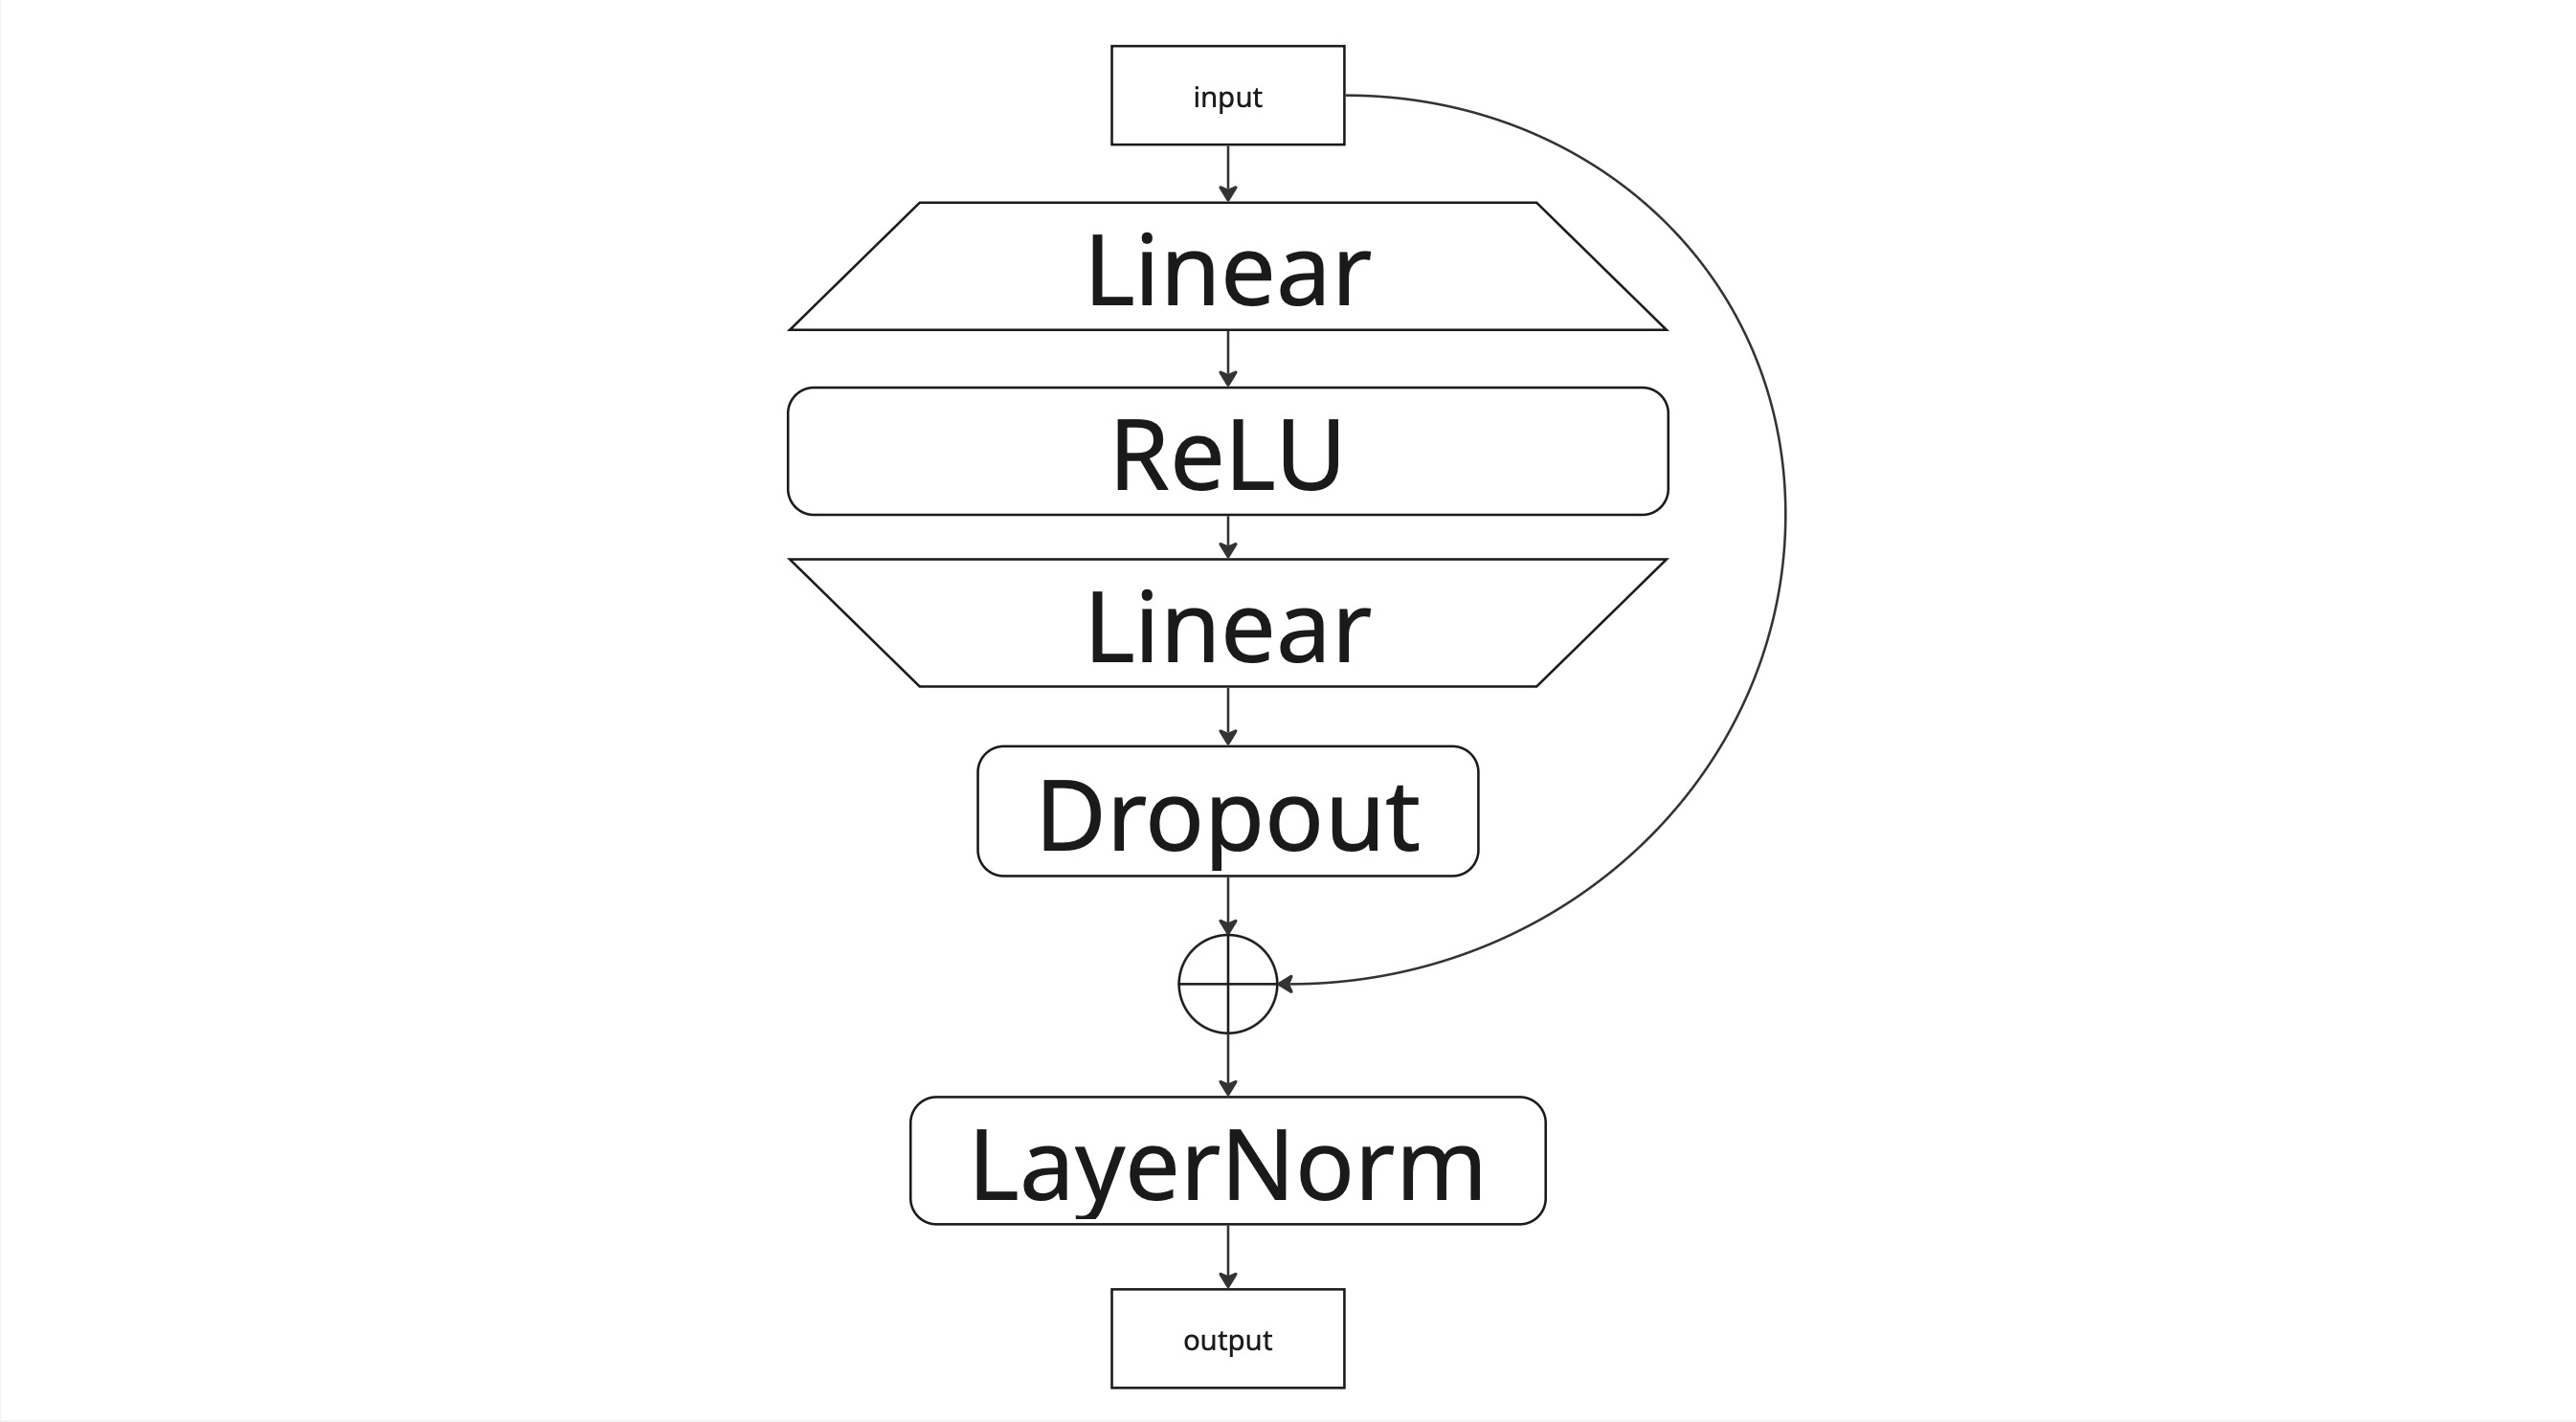

In [32]:
class MLPBlock(nn.Module):
    def __init__(self, dim, expand=4, dropout=0.0):
        super().__init__()
        self.mlp = nn.Sequential(
            #### ВАШ КОД ####
            nn.Linear(dim, dim * expand),
            nn.ReLU(),
            nn.Linear(dim * expand, dim),
            nn.Dropout(dropout)
        )
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        # return ... # ВАШ КОД
        residual = x
        x = self.mlp(x)
        x = residual + x  # Добавляем исходный вход
        x = self.norm(x)  # Нормализуем результат
        return x

#### 2. `MLPActHead` — голова политики 2 балла

Эта сеть принимает **стекированное состояние** (вектор размерности `state_dim`) и предсказывает **действие** (вектор размерности `act_dim`).  
Особенность архитектуры — **многократное возвращение к исходному состоянию** на промежуточных этапах:

1. **Первый этап**:  
   - Состояние проецируется в скрытое пространство `hidden_dim` → `proj0`.  
   - Обрабатывается через `MLPBlock` → `block0`.

2. **Второй этап**:  
   - К текущему скрытому представлению **конкатенируется исходное состояние** (`[x, state]`).  
   - Результат проецируется в `hidden_dim` → `proj1`.  
   - Обрабатывается через `MLPBlock` → `block1`.

3. **Третий этап**:  
   - Снова конкатенируется исходное состояние → `[x, state]`.  
   - Проекция → `proj2`, затем `block2`.

4. **Финальный выход**:  
   - Линейная проекция `proj_end` преобразует скрытое представление в пространство действий.



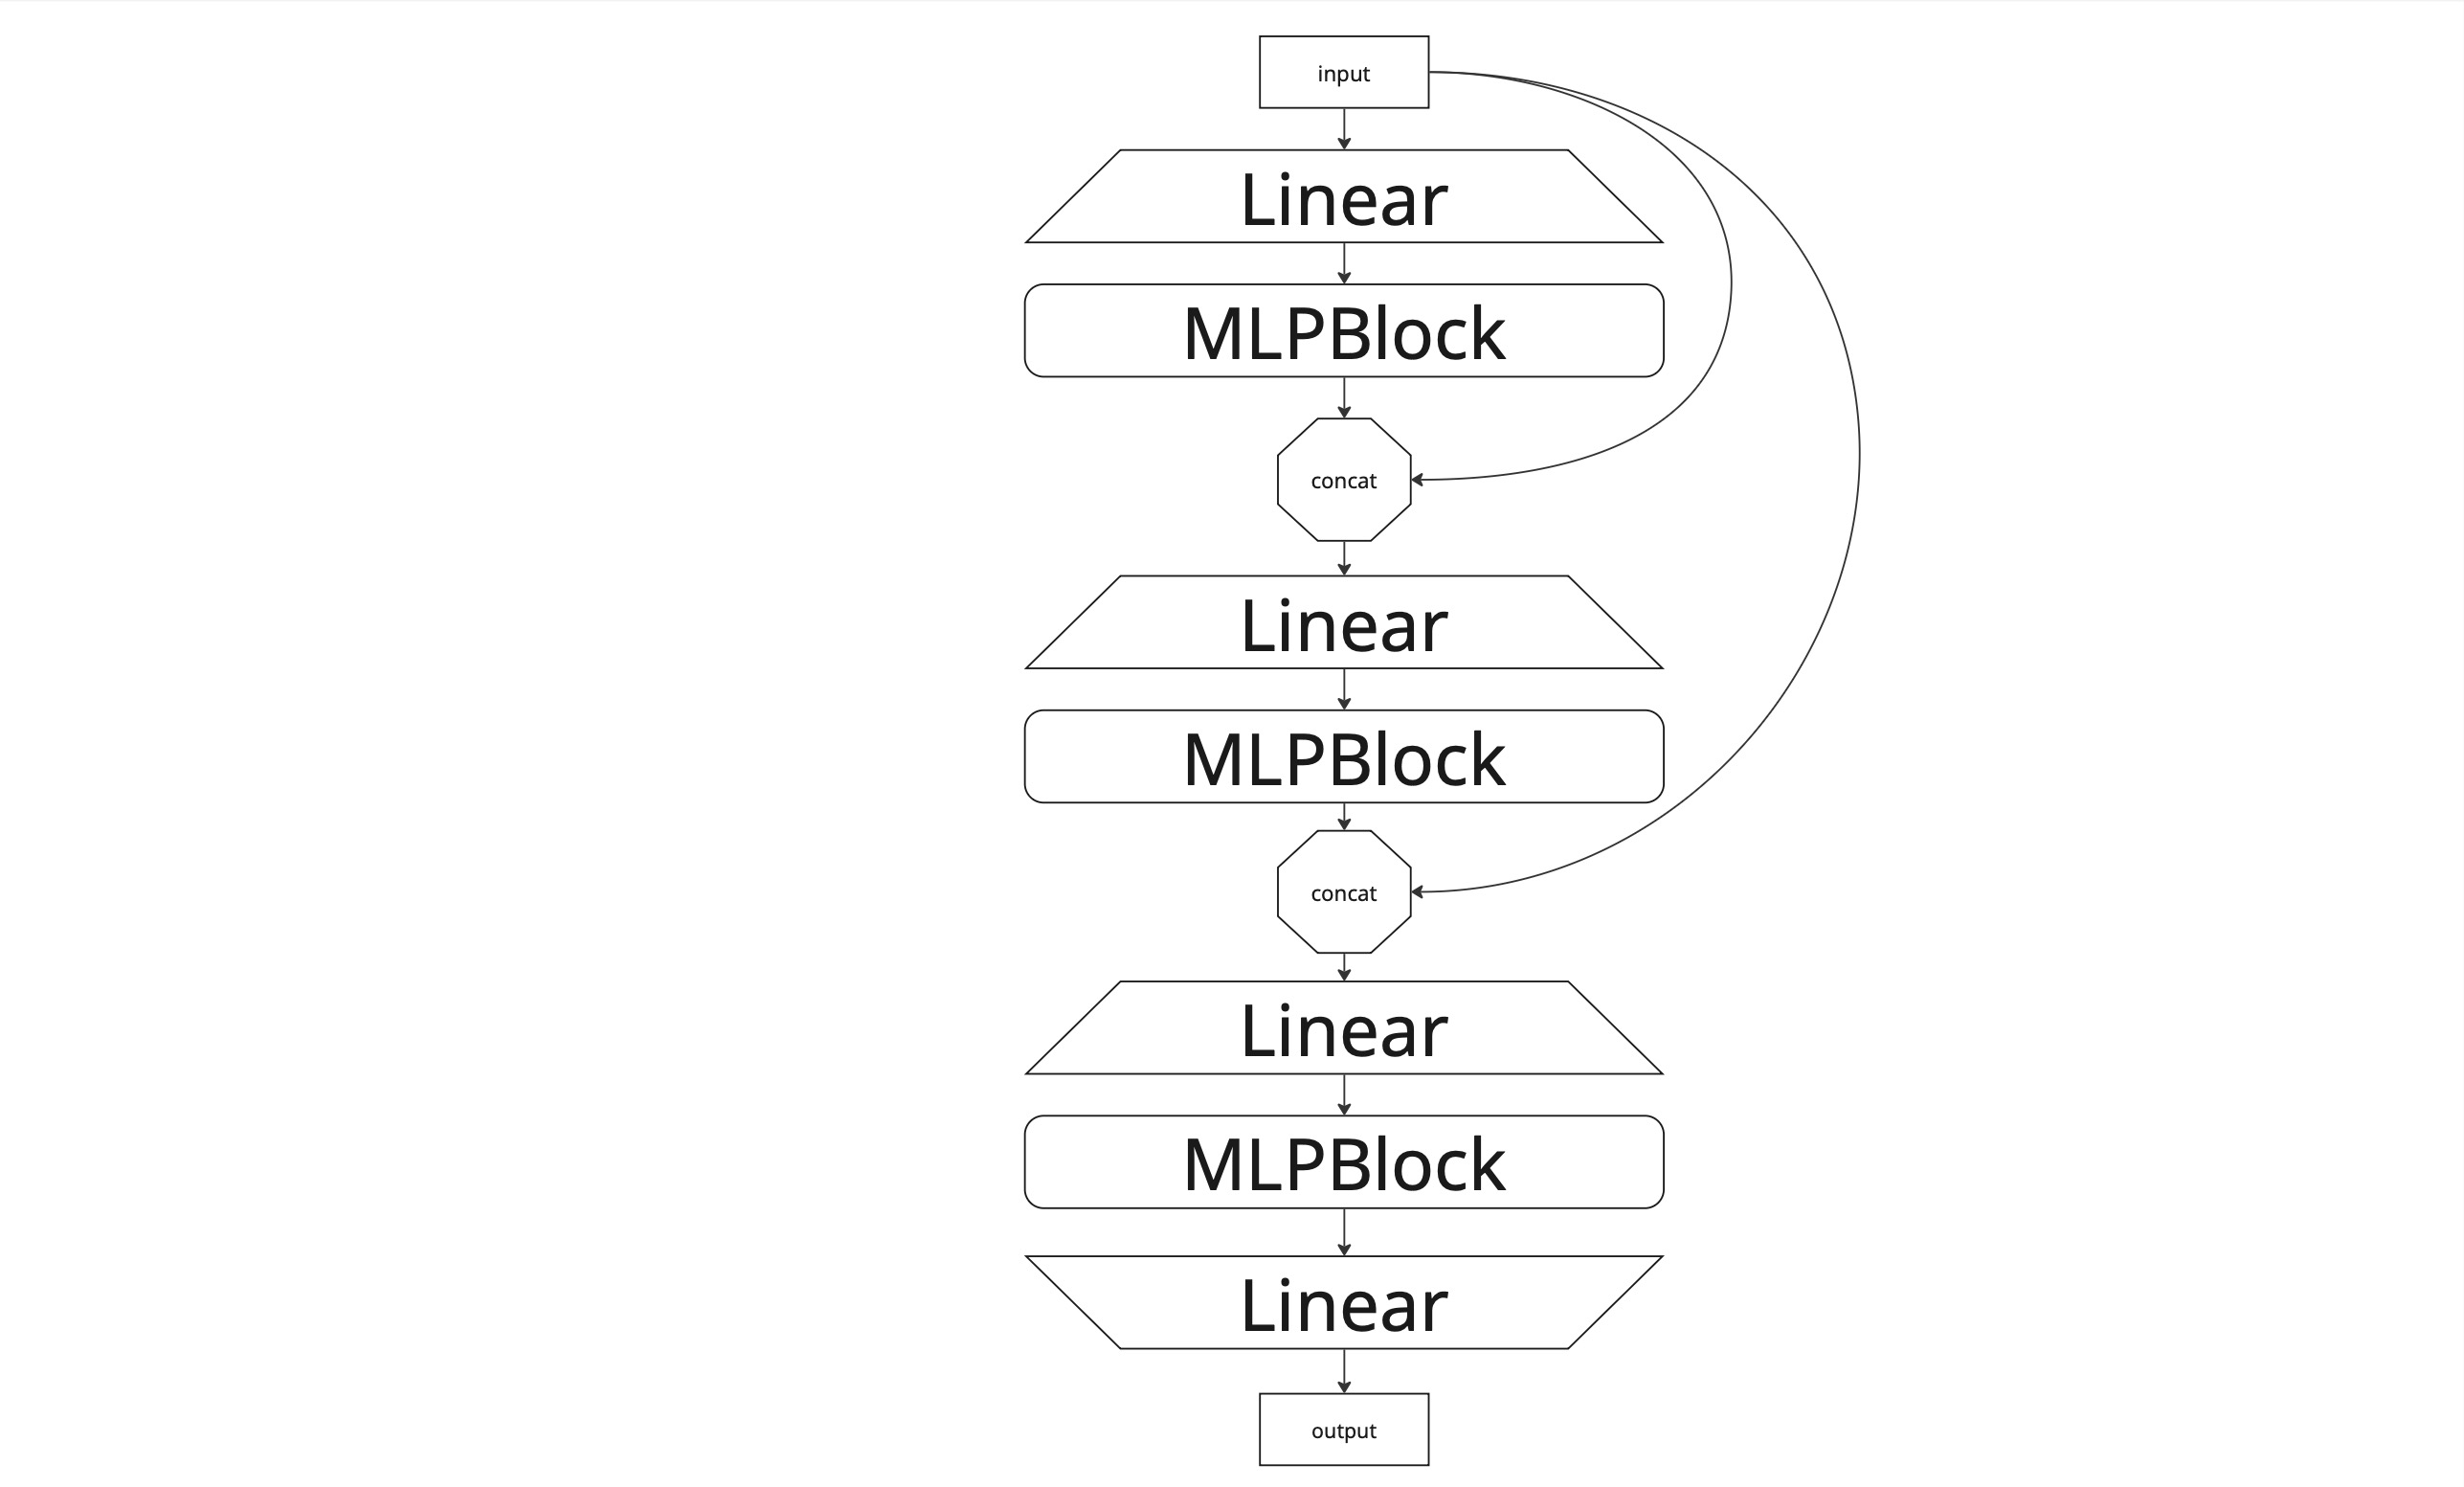

> 💡 **Зачем конкатенировать исходное состояние несколько раз?**  
> Это позволяет сети на каждом этапе «вспоминать» исходные признаки, не теряя контекст. Особенно полезно, когда `state_dim` велико, а промежуточные представления могут «забыть» важные детали. Такой приём используется в современных архитектурах (например, в ResNet с identity skip-connections или в некоторых transformer-based policy heads).

In [33]:
class MLPActHead(nn.Module):
    def __init__(self, act_dim, state_dim, hidden_dim, expand=4, dropout=0.0):
        super().__init__()
        #### ВАШ КОД ####
        self.state_dim = state_dim
        self.hidden_dim = hidden_dim

        # Первый этап
        self.proj0 = nn.Linear(state_dim, hidden_dim)
        self.block0 = MLPBlock(hidden_dim, expand, dropout)

        # Второй этап
        self.proj1 = nn.Linear(hidden_dim + state_dim, hidden_dim)
        self.block1 = MLPBlock(hidden_dim, expand, dropout)

        # Третий этап
        self.proj2 = nn.Linear(hidden_dim + state_dim, hidden_dim)
        self.block2 = MLPBlock(hidden_dim, expand, dropout)

        # Финальная проекция в пространство действий
        self.proj_end = nn.Linear(hidden_dim, act_dim)

    def forward(self, state):
        #### ВАШ КОД ###
        # return ...
        # Первый этап
        x = self.proj0(state)
        x = self.block0(x)

        # Второй этап: конкатенируем с исходным состоянием
        x = torch.cat([x, state], dim=-1)
        x = self.proj1(x)
        x = self.block1(x)

        # Третий этап: снова конкатенируем с исходным состоянием
        x = torch.cat([x, state], dim=-1)
        x = self.proj2(x)
        x = self.block2(x)

        # Финальная проекция
        action = self.proj_end(x)
        return action


In [34]:
bc_actor = MLPActHead(dataset.action_dim, dataset.state_dim * frame_stack, 32).to(device)

In [35]:
import torchinfo

torchinfo.summary(
    bc_actor, input_size=[(1, dataset.state_dim * frame_stack)]
)


Layer (type:depth-idx)                   Output Shape              Param #
MLPActHead                               [1, 6]                    --
├─Linear: 1-1                            [1, 32]                   1,120
├─MLPBlock: 1-2                          [1, 32]                   --
│    └─Sequential: 2-1                   [1, 32]                   --
│    │    └─Linear: 3-1                  [1, 128]                  4,224
│    │    └─ReLU: 3-2                    [1, 128]                  --
│    │    └─Linear: 3-3                  [1, 32]                   4,128
│    │    └─Dropout: 3-4                 [1, 32]                   --
│    └─LayerNorm: 2-2                    [1, 32]                   64
├─Linear: 1-3                            [1, 32]                   2,144
├─MLPBlock: 1-4                          [1, 32]                   --
│    └─Sequential: 2-3                   [1, 32]                   --
│    │    └─Linear: 3-5                  [1, 128]                  4,224


## Обучение Behavioral Cloning (1 балл)

На этом этапе вы обучаете нейросеть **методом Behavioral Cloning (BC)** — простейшей формы imitation learning, при которой агент обучается **регрессии**: по входному состоянию предсказывать действие, которое совершил эксперт.

1. **Оптимизатор**  
   Используется `AdamW` с раздельной настройкой weight decay:
   - Для матриц (параметров размерности ≥2) — применяется регуляризация.
   - Для векторов (смещения, scale-параметры) — регуляризация отключена, чтобы не повредить адаптивные характеристики модели.

In [36]:
def get_optim_groups(model, weight_decay):
    return [
        # do not decay biases and single-column parameters (rmsnorm), those are usually scales
        {"params": (p for p in model.parameters() if p.dim() < 2), "weight_decay": 0.0},
        {
            "params": (p for p in model.parameters() if p.dim() >= 2),
            "weight_decay": weight_decay,
        },
    ]

learning_rate = 0.001

# init optimizer
optim = torch.optim.AdamW(
    params=get_optim_groups(bc_actor, 0.0),
    lr=learning_rate,
    fused=True,
)


2. **Планировщик скорости обучения** (learning rate scheduling)
   Реализован линейный **warmup + decay**:  
   - Сначала learning rate линейно растёт от 0 до максимума (в данном случае — сразу до максимума, так как `warmup_epochs = 0`),  
   - Затем линейно убывает до нуля к концу обучения.  
   Это стабилизирует ранние шаги обучения и улучшает сходимость.

In [37]:
import torch
import math
import functools


def _linear_decay_warmup(iteration, warmup_iterations, total_iterations):
    """
    Linear warmup from 0 --> 1.0, then linear decay to 0
    """
    if iteration < warmup_iterations:
        multiplier = iteration / warmup_iterations
    else:
        multiplier = 1.0 - ((iteration - warmup_iterations) / (total_iterations - warmup_iterations))
    return multiplier


def linear_annealing_with_warmup(optimizer, warmup_steps, total_steps):
    _decay_func = functools.partial(
        _linear_decay_warmup,
        warmup_iterations=warmup_steps,
        total_iterations=total_steps,
    )
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, _decay_func)
    return scheduler


In [38]:
num_epochs = 10
warmup_epochs = 0

total_updates = len(dataloader) * num_epochs
warmup_updates = len(dataloader) * warmup_epochs
scheduler = linear_annealing_with_warmup(optim, warmup_updates, total_updates)


3. **Функция потерь**  
   Используется **среднеквадратичная ошибка (MSE)** между предсказанным действием и действием эксперта:
   $$
   \mathcal{L} = \frac{1}{N} \sum_{i=1}^N \| a_{\text{pred}}^{(i)} - a_{\text{expert}}^{(i)} \|^2
   $$

In [39]:
import torch.nn.functional as F

for epoch in trange(num_epochs, desc="Epochs"):
    losses, n = 0, 0
    bc_actor.train()
    for batch in dataloader:

        states, target_action = [b.to(device) for b in batch]

        pred_action = bc_actor(states)
        loss = F.mse_loss(pred_action, target_action) # ВАШ КОД

        losses += loss.item()
        n += batch_size

        optim.zero_grad(set_to_none=True)
        loss.backward()

        optim.step()
        scheduler.step()

    print(f"\n\nEpoch {epoch} latest batch loss:\n{losses / n}")

Epochs:  10%|█         | 1/10 [00:39<05:55, 39.45s/it]



Epoch 0 latest batch loss:
0.008312451666992274


Epochs:  20%|██        | 2/10 [01:18<05:11, 38.97s/it]



Epoch 1 latest batch loss:
0.0018153315148374532


Epochs:  30%|███       | 3/10 [01:56<04:31, 38.84s/it]



Epoch 2 latest batch loss:
0.0014884183657413814


Epochs:  40%|████      | 4/10 [02:35<03:52, 38.83s/it]



Epoch 3 latest batch loss:
0.001321958527289098


Epochs:  50%|█████     | 5/10 [03:14<03:13, 38.74s/it]



Epoch 4 latest batch loss:
0.0012070551059005083


Epochs:  60%|██████    | 6/10 [03:52<02:35, 38.76s/it]



Epoch 5 latest batch loss:
0.0011204674710461405


Epochs:  70%|███████   | 7/10 [04:31<01:56, 38.71s/it]



Epoch 6 latest batch loss:
0.0010519477682028081


Epochs:  80%|████████  | 8/10 [05:10<01:17, 38.67s/it]



Epoch 7 latest batch loss:
0.0009924902196216862


Epochs:  90%|█████████ | 9/10 [05:48<00:38, 38.64s/it]



Epoch 8 latest batch loss:
0.0009407610508205834


Epochs: 100%|██████████| 10/10 [06:27<00:00, 38.75s/it]



Epoch 9 latest batch loss:
0.0008938119292506599


4. **Оценка качества**  
   После обучения агент тестируется на 50 эпизодах в среде `cheetah/run`.  
   Важно: при оценке используется **та же глубина frame stacking**, что и при обучении (`frame_stack=2`), иначе входы будут несовместимы!

In [40]:
@torch.no_grad()
def evaluate_actor(
    env,
    bc_actor: MLPActHead,
    num_episodes: int = 1,
    seed: int = 0,
) -> List[float | int]:
    returns = []
    for ep in trange(num_episodes, desc="Evaluating", leave=False):
        total_reward = 0.0
        obs, info = env.reset(seed=seed + ep)
        done = False
        while not done:
            obs_ = torch.tensor(obs.copy(), device=device)
            obs_ = obs_[None].contiguous()  # [1 dim]

            action = bc_actor(obs_)

            obs, reward, terminated, truncated, info = env.step(
                action.squeeze().cpu().numpy()
            )
            done = terminated or truncated
            total_reward += reward
        returns.append(total_reward)

    return np.array(returns)


> 💡 **Интерпретация результата**  
> Если вы видите низкую награду, это означает, что BC-агент **не смог обобщить** поведение эксперта.  
> Возможные причины:
> - недостаточно данных (попробуйте обучиться на 1000 траекториях, а не на 10),
> - несовпадение распределений (covariate shift): агент попадает в состояния, которых не было в экспертном датасете,
> - слишком агрессивное обучение (попробуйте уменьшить learning rate или добавить dropout).

> **Для получения 1 балла**:  
> - Корректно запустить обучение BC на вашем датасете,  
> - Продемонстрировать, что loss убывает,  
> - Получить **награду не ниже 700** при оценке на 50 эпизодах (это ~85% от экспертного результата).

In [41]:
env = make_env("cheetah", "run", frame_stack=frame_stack, flatten_frames=True)()
returns = evaluate_actor(env, bc_actor, 50, RANDOM_SEED)

In [42]:
print(f"{np.mean(returns):.0f} +- {np.std(returns):.0f}")
print(f"{iqm(returns):.0f} +- {iqm_std(returns):.0f}")

825 +- 116
849 +- 4


## Анализ зависимости качества BC от размера датасета (5 баллов)

В этом задании вы исследуете, **как размер экспертного датасета влияет на качество обученной политики**. Это важный вопрос в imitation learning: слишком маленький датасет приводит к переобучению, а слишком большой — к высоким вычислительным затратам.

- Обучите BC-агентов на подмножествах одного и того же датасета, используя разное количество траекторий:  
  **`[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]`**.
- Для каждого размера:
  1. Создайте `StackedDataset` с параметром `max_videos=N` (не нужно собирать отдельные HDF5-файлы!).
  2. Обучите новую сеть `MLPActHead` с нуля (важно: не дообучайте старую!).
  3. Оцените политику на **50 эпизодах** с фиксированным `seed=0`.
- В качестве метрики используйте **IQM (Interquartile Mean)** и **стандартное отклонение по IQM** (см. функции `iqm`, `iqm_std` из предыдущего раздела).

## Постройте графики:
  - **Ось X**: количество траекторий в датасете (логарифмический масштаб рекомендуется).
  - **Ось Y**: `IQM ± IQM_STD`,`MEAN ± STD`(2 графика) награды BC-агента: 2 кривые
    1. **In-distribution**: используйте те же сиды, что и в датасете (`seed=0, 1, ..., 49`).
    2. **Out-of-distribution**: используйте новые сиды, которых **нет в датасете** (`seed=5000, 5001, ..., 5049`).

    > 💡 **Зачем это нужно?**  
    > Экспертный датасет собран с `seed=0..999`. Если вы оцениваете BC на `seed=0..49`, агент может «вспомнить» поведение из датасета (особенно при малом числе траекторий). Оценка на новых сидах покажет **настоящую обобщающую способность**.

#### Советы:
- Используйте одинаковые гиперпараметры (learning rate, batch size, архитектуру) для всех запусков.
- Сохраняйте результаты в список/словарь, чтобы построить график в конце.


In [43]:
#### ВАШ КОД ####
sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
results_in = []
results_out = []

num_epochs = 10
learning_rate = 0.001
batch_size = 64

for size in sizes:
    print(f"Старт обучения на датасете размером {size}")

    # Создаем StackedDataset
    train_dataset = StackedDataset(
        hdf5_path=dataset_path,
        frame_stack=frame_stack,
        max_videos=size
    )

    # Создаем DataLoader
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=min(batch_size, len(train_dataset)),
        shuffle=True
    )

    # Создаем новую сеть MLPActHead
    bc_actor = MLPActHead(
        act_dim=env.action_space.shape[0],
        state_dim=np.prod(env.observation_space.shape),
        hidden_dim=256,
        dropout=0.1
    ).to(device)

    # Оптимизатор
    optim = torch.optim.AdamW(
        params=get_optim_groups(bc_actor, 0.0),
        lr=learning_rate,
        fused=True
    )

    total_updates = len(train_dataloader) * num_epochs
    scheduler = linear_annealing_with_warmup(optim, 0, total_updates)

    # Обучение
    for epoch in trange(num_epochs, desc="Epochs", leave=False):
        bc_actor.train()
        for batch in train_dataloader:
            states, target_actions = [b.to(device) for b in batch]

            pred_actions = bc_actor(states)
            loss = F.mse_loss(pred_actions, target_actions)

            optim.zero_grad(set_to_none=True)
            loss.backward()
            optim.step()
            scheduler.step()

    # In-Distribution
    env_in = make_env("cheetah", "run", frame_stack=frame_stack, flatten_frames=True)()
    returns_in = evaluate_actor(env_in, bc_actor, num_episodes=50, seed=0)
    env_in.close()

    # Out-of-Distribution
    env_out = make_env("cheetah", "run", frame_stack=frame_stack, flatten_frames=True)()
    returns_out = evaluate_actor(env_out, bc_actor, num_episodes=50, seed=5000)
    env_out.close()

    results_in.append({
        'size': size,
        'iqm': iqm(returns_in),
        'iqm_std': iqm_std(returns_in),
    })

    results_out.append({
        'size': size,
        'iqm': iqm(returns_out),
        'iqm_std': iqm_std(returns_out),
    })

    print(f"In-Distribution: {round(results_in[-1]['iqm'], 2)} ± {round(results_in[-1]['iqm_std'], 2)}")
    print(f"Out-of-Distribution: {round(results_out[-1]['iqm'], 2)} ± {round(results_out[-1]['iqm_std'], 2)}")
    print(f"Разница между In-Distribution и Out-of-Distribution: {round(results_in[-1]['iqm'] - results_out[-1]['iqm'], 2)}")

Старт обучения на датасете размером 2
Loaded 2 trajectories from /content/drive/MyDrive/rl/hw3/hdf


In-Distribution: 87.38 ± 32.61
Out-of-Distribution: 73.23 ± 29.6
Разница между In-Distribution и Out-of-Distribution: 14.15
Старт обучения на датасете размером 4
Loaded 4 trajectories from /content/drive/MyDrive/rl/hw3/hdf


In-Distribution: 122.21 ± 25.83
Out-of-Distribution: 98.76 ± 24.26
Разница между In-Distribution и Out-of-Distribution: 23.45
Старт обучения на датасете размером 8
Loaded 8 trajectories from /content/drive/MyDrive/rl/hw3/hdf


In-Distribution: 114.06 ± 26.59
Out-of-Distribution: 110.05 ± 17.92
Разница между In-Distribution и Out-of-Distribution: 4.0
Старт обучения на датасете размером 16
Loaded 16 trajectories from /content/drive/MyDrive/rl/hw3/hdf


In-Distribution: 102.62 ± 16.11
Out-of-Distribution: 98.83 ± 15.25
Разница между In-Distribution и Out-of-Distribution: 3.78
Старт обучения на датасете размером 32
Loaded 32 trajectories from /content/drive/MyDrive/rl/hw3/hdf


In-Distribution: 177.09 ± 56.52
Out-of-Distribution: 175.38 ± 38.94
Разница между In-Distribution и Out-of-Distribution: 1.7
Старт обучения на датасете размером 64
Loaded 64 trajectories from /content/drive/MyDrive/rl/hw3/hdf


In-Distribution: 415.06 ± 209.54
Out-of-Distribution: 569.99 ± 213.71
Разница между In-Distribution и Out-of-Distribution: -154.93
Старт обучения на датасете размером 128
Loaded 128 trajectories from /content/drive/MyDrive/rl/hw3/hdf


In-Distribution: 832.58 ± 10.57
Out-of-Distribution: 808.73 ± 51.84
Разница между In-Distribution и Out-of-Distribution: 23.84
Старт обучения на датасете размером 256
Loaded 256 trajectories from /content/drive/MyDrive/rl/hw3/hdf


In-Distribution: 841.81 ± 7.54
Out-of-Distribution: 841.26 ± 8.34
Разница между In-Distribution и Out-of-Distribution: 0.56
Старт обучения на датасете размером 512
Loaded 512 trajectories from /content/drive/MyDrive/rl/hw3/hdf


In-Distribution: 842.96 ± 7.15
Out-of-Distribution: 840.83 ± 5.23
Разница между In-Distribution и Out-of-Distribution: 2.13
Старт обучения на датасете размером 1024
Loaded 1024 trajectories from /content/drive/MyDrive/rl/hw3/hdf


In-Distribution: 843.06 ± 6.21
Out-of-Distribution: 847.32 ± 6.13
Разница между In-Distribution и Out-of-Distribution: -4.25


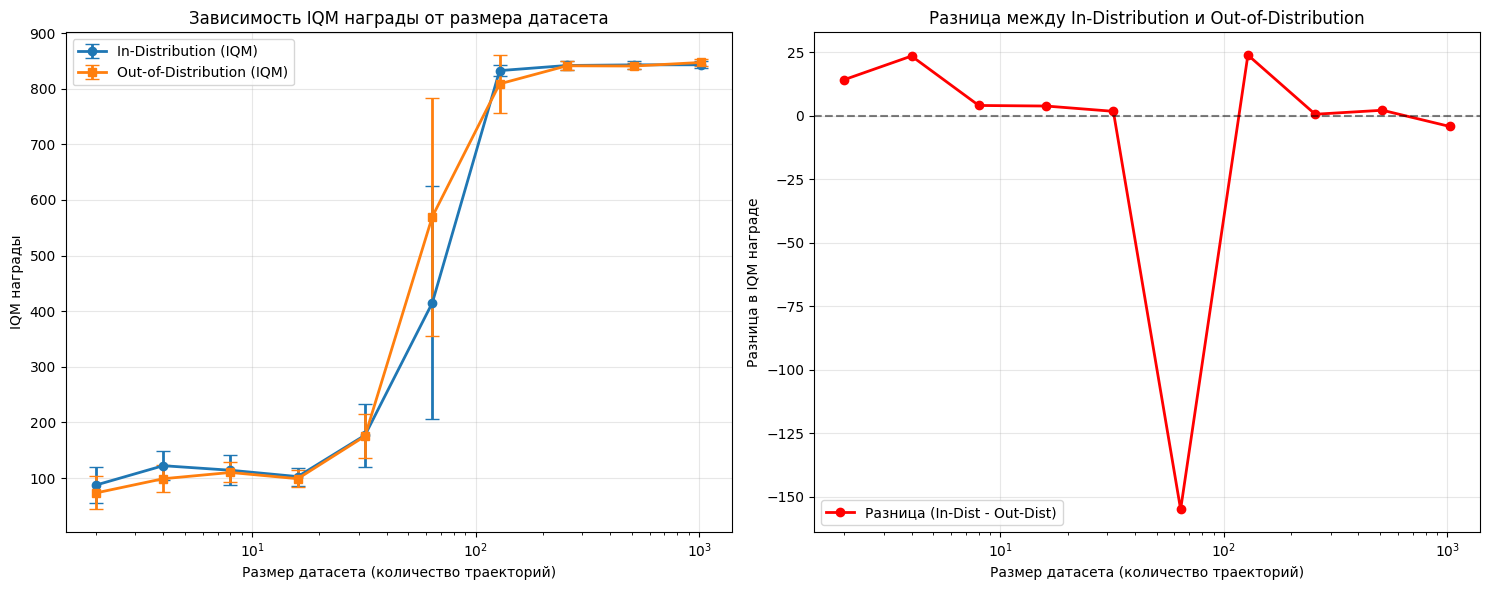

In [45]:
#### ВАШ КОД ####
import pandas as pd

# Создаем DataFrame из результатов
df_in = pd.DataFrame(results_in)
df_out = pd.DataFrame(results_out)

# Создаем фигуру с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# График 1: IQM с доверительными интервалами
ax1.errorbar(df_in['size'], df_in['iqm'], yerr=df_in['iqm_std'],
            label='In-Distribution (IQM)', marker='o', linewidth=2, capsize=5)
ax1.errorbar(df_out['size'], df_out['iqm'], yerr=df_out['iqm_std'],
            label='Out-of-Distribution (IQM)', marker='s', linewidth=2, capsize=5)

ax1.set_xscale('log')
ax1.set_xlabel('Размер датасета (количество траекторий)')
ax1.set_ylabel('IQM награды')
ax1.set_title('Зависимость IQM награды от размера датасета')
ax1.legend()
ax1.grid(True, alpha=0.3)

# График 2: Разница между In-Distribution и Out-of-Distribution
differences = df_in['iqm'].values - df_out['iqm'].values
ax2.plot(df_in['size'], differences, marker='o', linewidth=2, color='red', label='Разница (In-Dist - Out-Dist)')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)

ax2.set_xscale('log')
ax2.set_xlabel('Размер датасета (количество траекторий)')
ax2.set_ylabel('Разница в IQM награде')
ax2.set_title('Разница между In-Distribution и Out-of-Distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Dagger  (5 баллов)

**Behavioral Cloning (BC)** страдает от так называемого **covariate shift**: обученная политика может отклониться от экспертной траектории и попасть в состояния, которых не было в датасете. В таких состояниях она ведёт себя непредсказуемо, что усугубляет ошибку — и так далее.

Алгоритм **DAgger (Dataset Aggregation)** решает эту проблему **итеративно**:
1. На каждой итерации агент собирает траектории, используя **текущую политику**.
2. Для каждого посещённого состояния запрашивается **действие от эксперта**.
3. Пары `(состояние, экспертное_действие)` добавляются в обучающий датасет.
4. Политика переобучается на расширенном датасете.

#### 🔧 Вспомогательные компоненты

Чтобы упростить реализацию, мы рекомендуем использовать:

1. **`UpdateDataset`** — наследник `StackedDataset`, который поддерживает метод `.update(new_states, new_actions)`.  
   → **Важно**: передавайте **исходные состояния** (`obs` размерности 17), **НЕ стекированные**!  
   → Датасет сам позаботится о frame stacking при обучении.

In [46]:
class UpdateDataset(StackedDataset):

    def update(self, new_states, new_actions):
        state_dim = self.states[0].shape[-1]
        assert state_dim == self.state_dim, "Your state_dim in new_states != state_dim in dataset. Check that you do NOT collect frame_stacked states."

        new_states = [torch.tensor(s, device=self.device) for s in new_states]
        new_actions = [torch.tensor(a, device=self.device) for a in new_actions]

        self.states.extend(new_states)
        self.actions.extend(new_actions)

        self.traj_len = self.states[0].shape[0]

In [47]:
dataset = UpdateDataset(dataset_path, frame_stack, device, max_videos=1024)# ВАШ КОД)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

Loaded 1024 trajectories from /content/drive/MyDrive/rl/hw3/hdf


2. **`log_actor_trajectories_with_expert_actions(...)`** — функция, которая:
   - Собирает траектории с помощью **вашего BC-агента**,
   - Для **каждого состояния** запрашивает **действие у эксперта**,
   - Возвращает списки: `states` (исходные, не стекированные! (без frame-stack)), `actions` (экспертные), и `returns`.

In [48]:
@torch.no_grad()
def log_actor_trajectories_with_expert_actions(
    env,
    expert: Agent,
    bc_actor: MLPActHead,
    num_episodes: int = 1,
    seed: int = 0,
) -> List[float | int]:
    states_arr = []
    actions_arr = []
    returns = []
    for ep in trange(num_episodes, desc="Evaluating", leave=False):
        states = []
        actions = []
        total_reward = 0.0
        obs, info = env.reset(seed=seed + ep)
        done = False
        while not done:

            #### ВАШ КОД ####
             # Получаем действие от BC-агента для текущего состояния
            obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            bc_action_tensor = bc_actor(obs_tensor)
            bc_action = bc_action_tensor.squeeze(0).cpu().numpy()

            # Получаем экспертное действие для текущего состояния
            original_obs_for_expert = obs[-obs.shape[0] // frame_stack:]  # последний кадр из стека
            expert_action = expert.act_numpy(original_obs_for_expert, greedy=True)

            # Сохраняем текущее состояние (исходное, без frame-stack)
            states.append(original_obs_for_expert)

            # Сохраняем экспертное действие
            actions.append(expert_action)

            # Выполняем действие BC-агента в среде
            next_obs, rew, term, trunc, _ = env.step(bc_action)

            # Обновляем суммарную награду
            total_reward += rew

            # Переходим к следующему состоянию
            obs = next_obs
            done = any([term, trunc])
            #### ВАШ КОД ####

        returns.append(total_reward)
        states_arr.append(np.array(states))
        actions_arr.append(np.array(actions))

    return states_arr, actions_arr, np.array(returns)


In [49]:
states, actions, returns = log_actor_trajectories_with_expert_actions(env, expert, bc_actor, num_episodes=2, seed=123)

In [50]:
# тут можно самостоятельно проверить правильность (отдебажить) добавление собранных states, actions в датасет
# Инициализируем тестовый датасет с ограничением
test_dataset = UpdateDataset(
    hdf5_path=dataset_path,
    frame_stack=frame_stack,
    device=device,
    max_videos=3
)

# Получаем параметры датасета
state_dim = test_dataset.state_dim
action_dim = test_dataset.action_dim

print(f"Размерность состояния: {state_dim}")
print(f"Размерность действия: {action_dim}")
print(f"Исходный размер датасета: {len(test_dataset.states)} элементов")

# Собираем демонстрационные траектории
demo_states, demo_actions, performance_returns = log_actor_trajectories_with_expert_actions(
    env, expert, bc_actor, num_episodes=2, seed=777
)

# Проверяем целостность собранных данных
if not demo_states or not demo_actions:
    raise ValueError("Не удалось собрать данные траекторий")

episode_lengths = [len(episode) for episode in demo_states]
total_steps = sum(episode_lengths)

print(f"Собрано траекторий: {len(demo_states)}")
print(f"Длины эпизодов: {episode_lengths}")
print(f"Общее количество шагов: {total_steps}")
print(f"Награды за эпизоды: {performance_returns}")

# Валидация размерностей данных
for ep_idx, (episode_states, episode_actions) in enumerate(zip(demo_states, demo_actions)):
    if len(episode_states) != len(episode_actions):
        raise ValueError(f"Эпизод {ep_idx}: несоответствие states ({len(episode_states)}) и actions ({len(episode_actions)})")

    # Проверяем каждое состояние и действие в эпизоде
    for step_idx, (state, action) in enumerate(zip(episode_states, episode_actions)):
        if state.shape != (state_dim,):
            raise ValueError(f"Эпизод {ep_idx}, шаг {step_idx}: неверная размерность состояния {state.shape}")
        if action.shape != (action_dim,):
            raise ValueError(f"Эпизод {ep_idx}, шаг {step_idx}: неверная размерность действия {action.shape}")

print("Размерности всех состояний и действий корректны")

# Запоминаем начальное состояние датасета
initial_dataset_size = len(test_dataset.states)
print(f"Размер датасета до обновления: {initial_dataset_size}")

# Обновляем датасет новыми данными
for ep_states, ep_actions in zip(demo_states, demo_actions):
    test_dataset.update(ep_states, ep_actions)

# Проверяем результат обновления
final_dataset_size = len(test_dataset.states)
added_elements = final_dataset_size - initial_dataset_size

print(f"Размер датасета после обновления: {final_dataset_size}")
print(f"Добавлено элементов: {added_elements}")
print(f"Ожидалось добавить: {total_steps}")

if added_elements != total_steps:
    raise ValueError(f"Несоответствие добавленных элементов: {added_elements} vs ожидалось {total_steps}")

# Проверяем корректность frame stacking
test_indices = [0, initial_dataset_size, final_dataset_size - 1]  # Проверяем разные позиции

for idx in test_indices:
    if idx < final_dataset_size:  # Проверяем существующие индексы
        stacked_state, corresponding_action = test_dataset[idx]
        expected_stack_dim = state_dim * frame_stack

        if stacked_state.shape[0] != expected_stack_dim:
            raise ValueError(
                f"Элемент {idx}: неверная размерность после stacking. "
                f"Получено {stacked_state.shape[0]}, ожидается {expected_stack_dim}"
            )

        print(f"Элемент {idx}: frame stacking корректен (dim={stacked_state.shape[0]})")

print("Все проверки успешно пройдены!")

Loaded 3 trajectories from /content/drive/MyDrive/rl/hw3/hdf
Размерность состояния: 17
Размерность действия: 6
Исходный размер датасета: 3 элементов


Собрано траекторий: 2
Длины эпизодов: [1000, 1000]
Общее количество шагов: 2000
Награды за эпизоды: [829.52419295 845.93428457]
Размерности всех состояний и действий корректны
Размер датасета до обновления: 3
Размер датасета после обновления: 2003
Добавлено элементов: 2000
Ожидалось добавить: 2000
Элемент 0: frame stacking корректен (dim=34)
Элемент 3: frame stacking корректен (dim=34)
Элемент 2002: frame stacking корректен (dim=34)
Все проверки успешно пройдены!


#### Требования к реализации

Выполните **5-10 итераций DAgger**:

- **Инициализация**:  
  Инициализируйте `UpdateDataset` с `max_videos=100` (или 50–300) — это ваш стартовый датасет от эксперта.

- **На каждой итерации**:
  1. Создайте **новую сеть** `MLPActHead` (обучайте **с нуля**, не дообучайте!).
  2. Обучите её на **текущем датасете** (используйте тот же цикл обучения, что и в BC).
  3. Соберите **10-20 новых траекторий** с помощью `log_actor_trajectories_with_expert_actions(...)`.
  4. Обновите датасет: `dataset.update(states, actions)`.
  5. **Оцените** политику: выведите `IQM ± IQM_STD`,`MEAN ± STD` по возвращённым `returns`.

- **В конце**: постройте график `итерация → IQM`.

#### Что нужно для 5 баллов

- Корректная реализация цикла DAgger (10 итераций),
- Использование **экспертных действий** для состояний, порождённых **текущей политикой**,
- **Обучение BC-агента с нуля** на каждой итерации,
- Вывод **IQM и IQM_STD** после каждой итерации,
- **График** зависимости IQM от номера итерации,
- Интерпретация результатов: краткий **комментарий** (1–2 предложения) *сравнение DAgger и BC*
`
#### Пример структуры кода

```python
# Инициализация
env = make_env("cheetah", "run", render_enabled=False, frame_stack=frame_stack)()
dataset = UpdateDataset(dataset_path, frame_stack=frame_stack, device=device, max_videos=100)
dagger_scores = ... # логгирование метрик для графика

for iteration in range(10):
    # 1. Создать и обучить новую политику
    bc_actor = MLPActHead(...).to(device)
    # ... (цикл обучения)

    # 2. Собрать новые данные с помощью текущей политики + эксперта
    states, actions, returns = log_actor_trajectories_with_expert_actions(
        env, expert, bc_actor, num_episodes=10, seed=5000 + iteration * 10
    )

    # 3. Обновить датасет
    dataset.update(states, actions)

    # 4. Вывести результат
    print(f"Iteration {iteration} → IQM: {iqm(returns):.1f} ± {iqm_std(returns):.1f}")
```

In [52]:
#### ВАШ КОД ####
# Инициализация
env = make_env("cheetah", "run", render_enabled=False, frame_stack=frame_stack, flatten_frames=True)()
dataset = UpdateDataset(dataset_path, frame_stack=frame_stack, device=device, max_videos=100)

# Параметры обучения
num_dagger_iterations = 10
num_episodes_per_iteration = 10
num_epochs = 15
batch_size = 64
learning_rate = 0.001

dagger_scores_iqm = []
dagger_scores_std = []
dataset_sizes = []

for iteration in range(num_dagger_iterations):
    print(f"DAgger Итерация {iteration + 1}/{num_dagger_iterations}")

    # 1. Создать и обучить новую политику
    bc_actor = MLPActHead(
        act_dim=env.action_space.shape[0],
        state_dim=np.prod(env.observation_space.shape),
        hidden_dim=256,
        dropout=0.1
    ).to(device)

    # Создаем DataLoader для текущего датасета
    train_dataloader = DataLoader(
        dataset,
        batch_size=min(batch_size, len(dataset)),
        shuffle=True,
        drop_last=True
    )

    # Оптимизатор
    optim = torch.optim.AdamW(
        params=get_optim_groups(bc_actor, 0.0),
        lr=learning_rate,
        fused=True
    )

    total_updates = len(train_dataloader) * num_epochs
    scheduler = linear_annealing_with_warmup(optim, 0, total_updates)

    # Цикл обучения
    for epoch in trange(num_epochs, desc="Обучение", leave=False):
        bc_actor.train()
        for batch in train_dataloader:
            states, target_actions = [b.to(device) for b in batch]

            pred_actions = bc_actor(states)
            loss = F.mse_loss(pred_actions, target_actions)

            optim.zero_grad(set_to_none=True)
            loss.backward()
            optim.step()
            scheduler.step()

    # 2. Собрать новые данные с помощью текущей политики + эксперта
    states, actions, returns = log_actor_trajectories_with_expert_actions(
        env, expert, bc_actor, num_episodes=10, seed=5000 + iteration * 10
    )

    # 3. Обновить датасет
    dataset.update(states, actions)

    # 4. Вывести результат
    iqm_score = iqm(returns)
    iqm_std_score = iqm_std(returns)
    print(f"Iteration {iteration} → IQM: {iqm_score:.1f} ± {iqm_std_score:.1f}")

    # Сохраняем для графика
    dagger_scores_iqm.append(iqm_score)
    dagger_scores_std.append(iqm_std_score)

# Закрываем среду
env.close()

# Анализ результатов
final_iqm = dagger_scores_iqm[-1]
best_iqm = max(dagger_scores_iqm)
improvement = final_iqm - dagger_scores_iqm[0]

print(f"Финальный IQM: {final_iqm:.1f}")
print(f"Лучший IQM: {best_iqm:.1f}")
print(f"Улучшение за {num_dagger_iterations} итераций: {improvement:.1f}")

Loaded 100 trajectories from /content/drive/MyDrive/rl/hw3/hdf
DAgger Итерация 1/10


Iteration 0 → IQM: 775.0 ± 60.0
DAgger Итерация 2/10


Iteration 1 → IQM: 805.5 ± 29.4
DAgger Итерация 3/10


Iteration 2 → IQM: 841.7 ± 5.8
DAgger Итерация 4/10


Iteration 3 → IQM: 846.8 ± 5.8
DAgger Итерация 5/10


Iteration 4 → IQM: 844.5 ± 5.4
DAgger Итерация 6/10


Iteration 5 → IQM: 840.6 ± 11.5
DAgger Итерация 7/10


Iteration 6 → IQM: 838.5 ± 4.1
DAgger Итерация 8/10


Iteration 7 → IQM: 833.9 ± 8.1
DAgger Итерация 9/10


Iteration 8 → IQM: 847.3 ± 0.8
DAgger Итерация 10/10


Iteration 9 → IQM: 854.7 ± 2.6
Финальный IQM: 854.7
Лучший IQM: 854.7
Улучшение за 10 итераций: 79.7


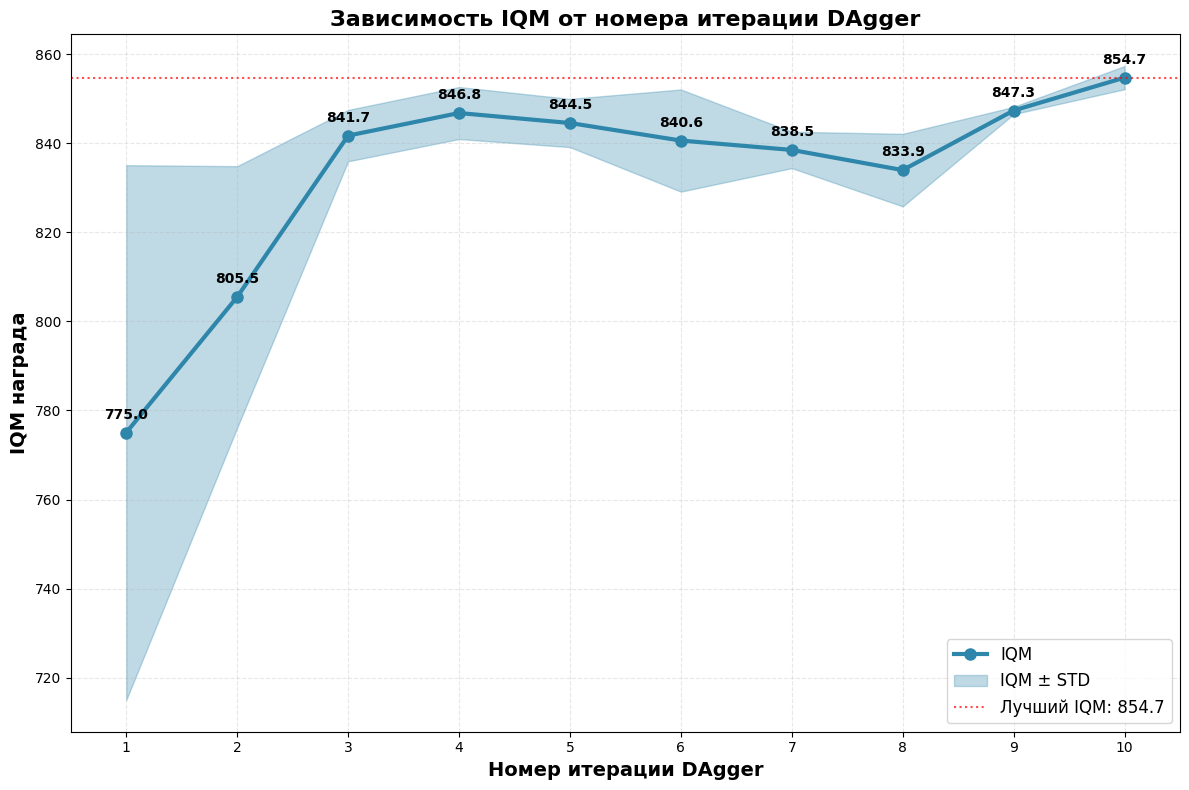

In [53]:
# Построение графика
plt.figure(figsize=(12, 8))

# Создаем данные для графика
iterations = range(1, len(dagger_scores_iqm) + 1)

# Основной график IQM с доверительными интервалами
plt.plot(iterations, dagger_scores_iqm,
         marker='o', linewidth=3, markersize=8, label='IQM', color='#2E86AB')

# Заливка для доверительного интервала (IQM ± IQM_STD)
plt.fill_between(iterations,
                 np.array(dagger_scores_iqm) - np.array(dagger_scores_std),
                 np.array(dagger_scores_iqm) + np.array(dagger_scores_std),
                 alpha=0.3, color='#2E86AB', label='IQM ± STD')

# Настройки графика
plt.xlabel('Номер итерации DAgger', fontsize=14, fontweight='bold')
plt.ylabel('IQM награда', fontsize=14, fontweight='bold')
plt.title('Зависимость IQM от номера итерации DAgger', fontsize=16, fontweight='bold')

# Сетка и легенда
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=12)

# Подписи точек с значениями
for i, (x, y) in enumerate(zip(iterations, dagger_scores_iqm)):
    plt.annotate(f'{y:.1f}',
                (x, y),
                textcoords="offset points",
                xytext=(0,10),
                ha='center',
                fontsize=10,
                fontweight='bold')

# Настройка осей
plt.xticks(iterations)
plt.xlim(0.5, len(iterations) + 0.5)

# Выделяем лучший результат
best_iteration = np.argmax(dagger_scores_iqm) + 1
best_iqm = dagger_scores_iqm[best_iteration - 1]
plt.axhline(y=best_iqm, color='red', linestyle=':', alpha=0.7,
           label=f'Лучший IQM: {best_iqm:.1f}')

plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


#### ВАШ ТЕКСТ ####
DAgger демонстрирует более стабильное улучшение производительности по сравнению с обычным Behavioral Cloning, поскольку итеративно корректирует ошибки политики на состояниях, которые она сама порождает, что приводит к лучшему обобщению и предотвращает накопление ошибок при исполнении.